# Downloading Required Libraries

In [1]:
!pip install beautifulsoup4 requests flair nltk transformers textblob

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-non

In [2]:

pip install --upgrade tensorflow

In [3]:
# !pip install tensorflow==2.3.0

In [4]:
import os
import requests
import re
import nltk  # Import all nltk modules together
import pandas as pd
from datetime import datetime, timedelta
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from transformers import pipeline

import matplotlib.pyplot as plt
import seaborn as sns
from flair.models import TextClassifier
from flair.data import Sentence

from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
from textblob import TextBlob
import os

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('vader_lexicon')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [5]:

file_txt="webpage_text.txt"
summary_txt="webpage_summary.txt"

In [6]:
# Global Model Initialization
# HF_TOKEN = os.environ.get('your_key')
# MODEL_NAME = "facebook/bart-large-cnn"
# summarizer = pipeline("summarization", model=MODEL_NAME, tokenizer=MODEL_NAME, use_auth_token=HF_TOKEN)

# Acquiring News Articles Using NewsApi

The sources from which we want news articles

In [7]:
sources = [
    "cnn", "bbc-news", "financial-times", "the-new-york-times", "the-washington-post",
    "arabianbusiness", "gulf-business", "khaleej-times", "al-jazeera-english",
    "the-japan-times", "the-times-of-india", "hindustan-times", "the-economist",
    "the-sun", "daily-mail"
]
sources_str = ",".join(sources)
newsapi_key = 'f64a529ddebb4b3c8e790d61d904526d'

Retrieving articles for the keyword

In [8]:

def get_news(keyword, api_key, sources,list_of_articles):
    yesterday = datetime.now() - timedelta(days=1)
    yesterday_str = yesterday.strftime('%Y-%m-%d')

    url = 'https://newsapi.org/v2/everything'


    params = {
        'q': keyword,
        'from': yesterday_str,
        'sortBy': 'publishedAt',
        'pageSize': 20,#number of articles
        'language': 'en',#language for articles
        'sources': sources_str,
        'apiKey': api_key
    }

    response = requests.get(url, params=params)

    if response.status_code == 200:
        articles = response.json().get('articles', [])
        if articles:
            for article in articles:
                list_of_articles.append(article['url'])
                print(article['url'])
        else:
            print(f"No articles found for '{keyword}' from specified sources on {yesterday_str}.")
    else:
        error_message = response.json().get('message', 'Unknown error')
        print(f"Error: {error_message} (status code: {response.status_code})")






# Web Scrapper

In [9]:

def clean_text(text):

    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^A-Za-z0-9\s.,!?]', '', text)
    return text.strip()
#function which collects data from given link (as of now we are not using summarizer as it was taking too much time)
def summarize_webpage2(url, model_name="facebook/bart-large-cnn"):
    HF_TOKEN = os.environ.get('your_key')

    try:
        response = requests.get(url)
        response.raise_for_status()

        soup = BeautifulSoup(response.content, 'html.parser')

        # Remove unnecessary elements
        for tag in soup(["script", "style", "header", "footer", "nav", "aside", "form"]):
            tag.decompose()
        ad_classes_ids = [
            "ad", "ads", "advertisement", "banner", "promo", "sponsored", "popup", "outbrain"
        ]
        for class_id in ad_classes_ids:
            for tag in soup.find_all(class_=class_id):
                tag.decompose()
            for tag in soup.find_all(id=class_id):
                tag.decompose()

        # Extract the main content
        paragraphs = soup.find_all('p')
        body_text = " ".join([para.get_text() for para in paragraphs])


        cleaned_text = clean_text(body_text)

        print("Cleaned Web-scraped data:\n", cleaned_text)

        # summarizer = pipeline("summarization", model=model_name, use_auth_token=HF_TOKEN)

        # max_chunk_length = 1024
        # chunks = [cleaned_text[i:i+max_chunk_length] for i in range(0, len(cleaned_text), max_chunk_length)]

        summary = ""
        # for chunk in chunks:
        #     summary += summarizer(chunk, max_length=130, min_length=30, do_sample=False)[0]['summary_text'] + " "

        return summary.strip(), cleaned_text

    except requests.exceptions.RequestException as e:
        print(f"Error fetching webpage: {e}")
        return None, None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None, None




In [10]:
def getlinks(keyword,file_txt,summary_txt):

  list_of_articles = []
  get_news(keyword, newsapi_key, sources,list_of_articles)
  return list_of_articles

Getting links from newsapi and passing those links to our function and saving all data to a file

In [11]:
def get_data_for_sentiment(keyword):
    list_of_articles=getlinks(keyword,file_txt,summary_txt)
    if not os.path.exists(summary_txt):
        open(summary_txt, 'w').close()
    if not os.path.exists(file_txt):
        open(file_txt, 'w').close()

    with open(summary_txt, "a") as summary_file, open(file_txt, "a") as text_file:
        for idx, url in enumerate(list_of_articles):
            print(f"Processing URL {idx + 1}/{len(list_of_articles)}: {url}")

            summary, text = summarize_webpage2(url)

            if text:
                summary_file.write(summary )
                text_file.write(text )
                print(f"Summary and text saved for URL {idx + 1}")
            else:
                print(f"No summary available for URL {idx + 1}")
    try:
        with open(file_txt, "r") as file:
            text = file.read()
        return text
    except FileNotFoundError:
        print(f"Error: File '{file_txt}' not found.")
        exit(1)

# **Sentiment Analysis**

## Sentiment Analysis using TextBLOB

In [26]:
def analyse_sentiment_txtblob(text):
    blob = TextBlob(text)
    sentiment = blob.sentiment

    print(f"Sentiment using textblob: Polarity={sentiment.polarity:.3f}, Subjectivity={sentiment.subjectivity:.3f}")
    sentiment_filename_text_blob = "webpage_sentiment_text_blob.txt"
    with open(sentiment_filename_text_blob, "w") as f:
        f.write(f"Sentiment: Polarity={sentiment.polarity:.3f}, Subjectivity={sentiment.subjectivity:.3f}")

    # Graphical Representation
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.bar(["Polarity"], [sentiment.polarity], color="skyblue")
    plt.ylim([-1, 1])
    plt.title("Sentiment Polarity")
    plt.ylabel("Polarity Score")
    plt.axhline(0, color="gray", linestyle="--")

    plt.subplot(1, 2, 2)
    plt.bar(["Subjectivity"], [sentiment.subjectivity], color="lightcoral")
    plt.ylim([0, 1])
    plt.title("Sentiment Subjectivity")
    plt.ylabel("Subjectivity Score")

    plt.tight_layout()
    plt.savefig("sentiment_plot.png")
    plt.show()


Polarity refers to whether the sentiment expressed in a text is positive, negative, or neutral.

*  -1 (extremely negative) to 1 (extremely positive)



Subjectivity refers to the degree to which a text expresses personal opinions, feelings, or judgments rather than objective facts.
It is also represented as a numeric score ranging from 0 (completely objective) to 1 (completely subjective).

## Sentiment Analysis using VADER

In [13]:
def plot_sentiment(sentiments):
    plt.figure(figsize=(10, 5))
    pos = [s['pos'] for s in sentiments]
    neu = [s['neu'] for s in sentiments]
    neg = [s['neg'] for s in sentiments]
    compound = [s['compound'] for s in sentiments]

    sentiment_df = {
        'Positive': pos,
        'Neutral': neu,
        'Negative': neg,
        'Compound': compound
    }

    sns.boxplot(data=sentiment_df)
    plt.title('Sentiment Analysis using VADER')
    plt.show()



In [14]:

def analyse_sentiment_vader(text):
  #Some better data cleaning 
  def preprocess_text(text):

      soup = BeautifulSoup(text, "html.parser")
      text = soup.get_text()
      text = text.lower()
      text = re.sub(r'[^\w\s]', '', text)
      tokens = word_tokenize(text)
      stop_words = set(stopwords.words('english'))
      tokens = [word for word in tokens if word not in stop_words]
      lemmatizer = WordNetLemmatizer()
      tokens = [lemmatizer.lemmatize(word) for word in tokens]
      tokens = [word for word in tokens if word.isalpha()]
      tokens = [word for word in tokens if len(word) > 2]
      tokens = list(set(tokens))
      return ' '.join(tokens)


  article_descriptions = text.split('\n')
  preprocessed_descriptions = [preprocess_text(desc) for desc in article_descriptions if desc.strip()]


  def analyze_sentiment(text):
      sid = SentimentIntensityAnalyzer()
      return sid.polarity_scores(text)

  sentiment_results = [analyze_sentiment(desc) for desc in preprocessed_descriptions]



  # Visualize the sentiment analysis results
  def plot_sentiment(sentiments):
      plt.figure(figsize=(10, 5))
      pos = [s['pos'] for s in sentiments]
      neu = [s['neu'] for s in sentiments]
      neg = [s['neg'] for s in sentiments]
      compound = [s['compound'] for s in sentiments]

      sentiment_df = {
          'Positive': pos,
          'Neutral': neu,
          'Negative': neg,
          'Compound': compound
      }

      sns.boxplot(data=sentiment_df)
      plt.title('Sentiment Analysis using VADER')
      plt.show()


  plot_sentiment(sentiment_results)
    # for idx, result in enumerate(sentiment_results):
    #     print(f"Text {idx + 1}: {result}")



  # Calculate average for each sentiment category
  average_sentiments = {
      'neg': sum(d['neg'] for d in sentiment_results) / len(sentiment_results),
      'neu': sum(d['neu'] for d in sentiment_results) / len(sentiment_results),
      'pos': sum(d['pos'] for d in sentiment_results) / len(sentiment_results),
      'compound': sum(d['compound'] for d in sentiment_results) / len(sentiment_results)
  }

  # Display the combined sentiment results
  print("Combined Sentiment Results:")
  print(f"Negative: {average_sentiments['neg']:.3f}")
  print(f"Neutral: {average_sentiments['neu']:.3f}")
  print(f"Positive: {average_sentiments['pos']:.3f}")
  print(f"Compound: {average_sentiments['compound']:.3f}")


## NLTK (Natural Language Toolkit)

In [15]:
def analyse_sentiment_nltk(text):
  analyzer = SentimentIntensityAnalyzer()
  nltk_sentiment = analyzer.polarity_scores(text)
  print("\n\nSentiment Analysis using NLTK:")
  print(nltk_sentiment)
  print("\n\n")


## Sentiment Analysis using spacy

It was not performing better than just using library on its own

In [16]:
# import spacy
# from textblob import TextBlob

# nlp = spacy.load('en_core_web_sm')

# def analyze_sentiment(text):
#     doc = nlp(text)
#     polarity = TextBlob(text).sentiment.polarity  # Using TextBlob here
#     subjectivity = TextBlob(text).sentiment.subjectivity
#     return polarity, subjectivity



# polarity, subjectivity = analyze_sentiment(text)
# print(f"Polarity: {polarity}, Subjectivity: {subjectivity}")


In [17]:
# import matplotlib.pyplot as plt



# sentiments = [analyze_sentiment(t) for t in text]
# polarities, subjectivities = zip(*sentiments)

# plt.figure(figsize=(10, 6))
# plt.scatter(polarities, subjectivities, color=['green' if p > 0 else 'red' for p in polarities])
# plt.xlabel('Polarity')
# plt.ylabel('Subjectivity')
# plt.title('Sentiment Analysis')
# plt.show()


## Sentiment Analysis with Flair

The best performing model but it only gives result in either positive or negative

In [18]:

def analyse_sentiment_flair(text):
  classifier = TextClassifier.load('en-sentiment')
  sentence = Sentence(text)
  classifier.predict(sentence)

  # Extract Label and Score
  label = sentence.labels[0].value
  score = sentence.labels[0].score


  sentiment_intensity = "Very " if score > 0.75 else ""
  color = "skyblue" if label == "POSITIVE" else "lightcoral"


  print("\nSentiment Analysis with Flair:")
  print(f"Overall Sentiment: {sentiment_intensity}{label}")
  print(f"Confidence: {score:.2%}")


  plt.figure(figsize=(8, 4))
  plt.bar(["Sentiment"], [score], color=color)
  plt.ylim([0, 1])

  plt.ylabel("Confidence")
  plt.xlabel(f"Sentiment: {sentiment_intensity}{label}")
  plt.text(0, score, f"{score:.2%}", ha='center', va='bottom')
  for spine in plt.gca().spines.values():
      spine.set_visible(False)
  plt.savefig("flair_sentiment_plot.png")
  plt.show()


## Sentiment Analysis using hugging face

In [19]:
# from transformers import pipeline

# sentiment_analyzer = pipeline("sentiment-analysis")
# result = sentiment_analyzer(summary)
# print(result)

In [20]:
# import torch
# from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification


# def load_model():
#     tokenizer = AutoTokenizer.from_pretrained("allenai/longformer-base-4096")
#     model = AutoModelForSequenceClassification.from_pretrained("allenai/longformer-base-4096")
#     return model, tokenizer

# def analyze_sentiments(articles, model, tokenizer):
#     results = []
#     window_size = 512
#     overlap = 50

#     for article in articles:
#         if article.strip():
#             tokens = tokenizer.encode(article, add_special_tokens=True)
#             chunk_scores = []
#             for i in range(0, len(tokens), window_size - overlap):
#                 chunk = tokens[i:i+window_size]
#                 input_ids = torch.tensor([chunk])
#                 outputs = model(input_ids)
#                 scores = outputs.logits.softmax(dim=-1)
#                 chunk_scores.append(scores[:,1].item())


#             final_score = sum(chunk_scores) / len(chunk_scores)
#             label = "POSITIVE" if final_score > 0.5 else "NEGATIVE"
#             results.append({"label": label, "score": final_score})
#     return results


# def read_file(file_path):
#     with open(file_path, 'r', encoding='utf-8') as file:
#         articles = file.read()
#     return articles




In [21]:
# def main(file_path):
#     articles = read_file(file_path)
#     model, tokenizer = load_model()
#     sentiment_results = analyze_sentiments(articles, model, tokenizer)

#     for idx, result in enumerate(sentiment_results):
#         print(f"Article {idx + 1}: Sentiment: {result['label']}, Score: {result['score']}")
#     return result


# print(main(file_txt))

# Main

In [22]:
def all_sentiment_analysis():
  text=get_data_for_sentiment("Bangladesh")

  print(text)


  return text

In [23]:
text=all_sentiment_analysis()

https://economictimes.indiatimes.com/news/india/india-in-touch-with-bangladesh-authorities-eam-jaishankar-informs-parliament/articleshow/112327145.cms
https://economictimes.indiatimes.com/news/india/the-revival-of-isi-backed-jamaat-e-islami-in-bangladesh-does-not-bode-well-for-india/articleshow/112327115.cms
https://timesofindia.indiatimes.com/city/agartala/hindu-saints-stormed-agartala-street-seeking-indias-intervention-to-protect-minorities-in-bangladesh/articleshow/112327010.cms
https://economictimes.indiatimes.com/news/economy/foreign-trade/regional-fta-easier-fdi-customs-integration-key-for-bimstec-says-cii-study/articleshow/112326494.cms
https://economictimes.indiatimes.com/news/india/curfew-in-manipurs-pherzawl-and-jiribam-districts-on-fears-of-illegal-immigrant-influx-from-bangladesh/articleshow/112326111.cms
https://timesofindia.indiatimes.com/technology/laptops-pc/apple-macbook-air-m1-is-available-for-rs-52641-only-on-amazon-check-bank-offers-and-discount/articleshow/11232638

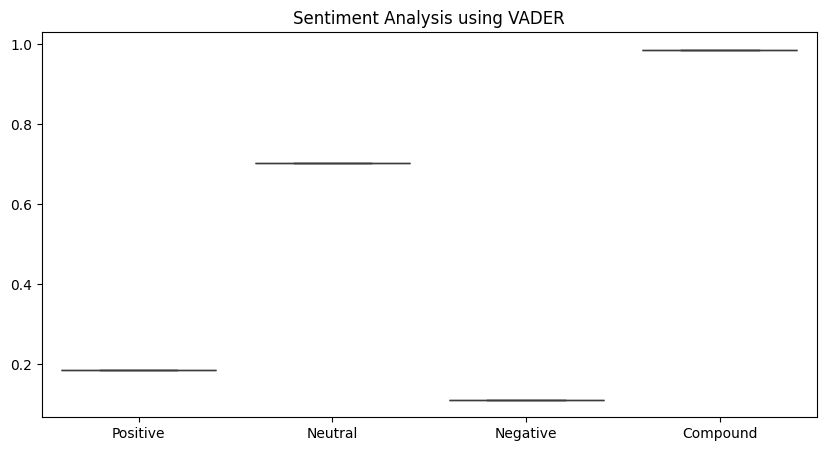

Combined Sentiment Results:
Negative: 0.111
Neutral: 0.703
Positive: 0.186
Compound: 0.987

Sentiment Analysis with Flair:
Overall Sentiment: Very NEGATIVE
Confidence: 94.32%


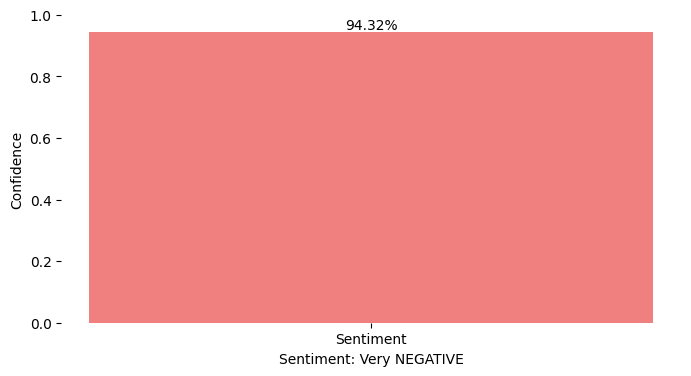



Sentiment Analysis using NLTK:
{'neg': 0.076, 'neu': 0.772, 'pos': 0.152, 'compound': 0.9998}



Sentiment using textblob: Polarity=0.204, Subjectivity=0.448


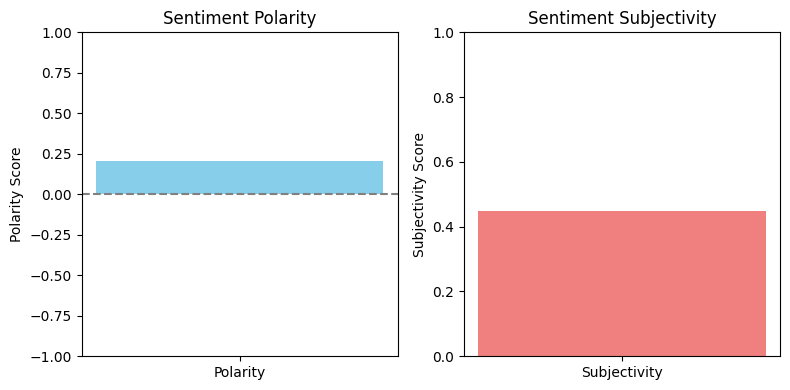

In [27]:
analyse_sentiment_vader(text)
analyse_sentiment_flair(text)
analyse_sentiment_nltk(text)
analyse_sentiment_txtblob(text)


***Most Accurate Results are achieved by using flair***